In [1]:
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

### Get success targets

In [8]:
city        = 'london'
outfolder   = '../ProcessedData/' + city + '/'
successdata = outfolder + 'venues_info/' + city + '_venues_success_measures.csv'
success     = pd.read_csv(successdata, sep = '\t', index_col = 0)

success.head()

,checkinsCount,tipCount,usersCount
4a5f9446f964a520e0bf1fe3,2500.0,75.0,1831.0
4abcec53f964a520b98720e3,1550.0,17.0,913.0
4abdc1c7f964a5206d8b20e3,5573.0,47.0,2777.0
4abe4502f964a520558c20e3,97190.0,575.0,80793.0
4abe5714f964a520d68c20e3,1507.0,54.0,1256.0


In [9]:
success['quartile'] = pd.qcut(success['checkinsCount'], 4, ['q1','q2','q3','q4'])
Q1 = list(success[success['quartile'] == 'q1'].index)
Q4 = list(success[success['quartile'] == 'q4'].index)

### Get success features

In [10]:
# basic stats of wards: bbox, length, area

outfolder    = '../ProcessedData/' + city + '/'
ward_stats_f = outfolder + 'venues_info/venues_ward_full.dat'
ward_stats   = pd.read_csv(ward_stats_f, sep = '\t', index_col = 0).drop(['ward'], axis=1)

ward_stats.reset_index(inplace=True)

ward_stats_Q1 = ward_stats[ward_stats['venue'].isin(Q1)]
ward_stats_Q4 = ward_stats[ward_stats['venue'].isin(Q4)]

ward_stats_Q1 = ward_stats_Q1.set_index('venue')
ward_stats_Q4 = ward_stats_Q4.set_index('venue')

ward_stats_Q1.head()

,lng,lat,lng0,lat0,lng1,lat1,length,area
venue,,,,,,,,
5887b2c524fd716347d8dbc5,-0.058680,51.539397,-0.076766,51.534089,-0.055241,51.544147,0.062448,0.000132
4e78e756e4cd13042a349351,-0.074062,51.524433,-0.077253,51.522378,-0.063978,51.531257,0.039425,0.000087
4cc1c39f306e224bd1dd8b6c,-0.123340,51.530972,-0.139999,51.527296,-0.122329,51.543034,0.063568,0.000181
4e11d4c77d8b4d5613ddbd90,-0.135021,51.514286,-0.158366,51.501861,-0.128997,51.520817,0.085100,0.000259
50acc16de4b0592296d77d91,-0.138559,51.516802,-0.158366,51.501861,-0.128997,51.520817,0.085100,0.000259


In [11]:
# category stats of wards: number of venues, fraction of food, nightlife..., entropy

ward_cats_f  = outfolder + 'venues_info/' + city + '_WARD_category_stats.csv'
ward_cats    = pd.read_csv(ward_cats_f, sep = '\t', index_col = 0).drop(['ward'], axis=1)

ward_cats.reset_index(inplace=True)
ward_cats_Q1 = ward_cats[ward_cats['index'].isin(Q1)]
ward_cats_Q4 = ward_cats[ward_cats['index'].isin(Q4)]

ward_cats_Q1 = ward_cats_Q1.set_index('index')
ward_cats_Q4 = ward_cats_Q4.set_index('index')

ward_cats_Q1.head()

,building,food,na,travel,Venues_num,parks_outdoors,Entropy,nightlife,shops,education,event,arts_entertainment
index,,,,,,,,,,,,
4ac51183f964a5204aa020e3,0.155340,0.343042,0.019417,0.045307,618,0.024272,0.753878,0.111650,0.250809,0.003236,0.006472,0.040453
4ac518b4f964a52068a020e3,0.202808,0.304086,0.009276,0.072700,3989,0.044372,0.827671,0.082477,0.166458,0.018551,0.014039,0.085234
4ac518b5f964a52094a020e3,0.198785,0.275632,0.016271,0.053127,5101,0.012743,0.770674,0.086062,0.273868,0.008234,0.005489,0.069790
4ac518b5f964a520b6a020e3,0.359375,0.334375,0.009375,0.040625,320,0.028125,0.700712,0.087500,0.103125,0.015625,0.003125,0.018750
4ac518b5f964a520c3a020e3,0.230522,0.273664,0.019317,0.046362,1553,0.018674,0.797989,0.114617,0.195750,0.007727,0.007083,0.086285


In [12]:
# venue similarity network stuff with threshold (1000 for now) 
# and
# user friendship network measures aggregated on the venue level

network_meas_f  = outfolder + '/networks/' + city + '_COMBINED_networkmeasures.csv'
network_meas    = pd.read_csv(network_meas_f, sep = ',', index_col = 0).replace([np.inf, -np.inf], np.nan).fillna(0.0)
network_meas.head()

network_meas.reset_index(inplace=True)
network_meas_Q1 = network_meas[network_meas['index'].isin(Q1)]
network_meas_Q4 = network_meas[network_meas['index'].isin(Q4)]

network_meas_Q1 = network_meas_Q1.set_index('index')
network_meas_Q4 = network_meas_Q4.set_index('index')

network_meas_Q1.head()

,degree_entropy,egosize_std,eigenvector_geo_entropy,betweenness_avg,constraint_geo_avg,egosize_entropy,eigenvector_std,strength_geo_entropy,constraint_avg,eigenvector_entropy,...,degree_avg,geo_size_of_ego_std,egosize_avg,geo_stdev_of_ego_entropy,geo_size_of_ego_entropy,clustering_avg,constraint_geo_std,strength_geo_avg,eigenvector_geo_avg,clustering_geo_avg
index,,,,,,,,,,,,,,,,,,,,,
4ac51183f964a5204aa020e3,0.000000,0.0,0.000000,240102.885400,0.092637,0.000000,0.000000,0.00000,0.055867,0.000000,...,44.0,0.0,25.0,0.000000,0.000000,0.021142,0.000000,117.830270,0.004671,0.065704
4ac518b4f964a52068a020e3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4ac518b5f964a52094a020e3,0.661563,1.0,0.639374,5763.022211,0.352254,0.673012,0.001368,0.44884,0.286717,0.474839,...,8.0,0.0,5.0,0.424928,0.693147,0.011111,0.010955,14.931374,0.000286,0.013206
4ac518b5f964a520b6a020e3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4ac518b5f964a520c3a020e3,0.000000,0.0,0.000000,113815.608204,0.070635,0.000000,0.000000,0.00000,0.057294,0.000000,...,38.0,0.0,21.0,0.000000,0.000000,0.031294,0.000000,108.146429,0.078216,0.097680


In [15]:
#merging all features

temp_Q1 = network_meas_Q1.join(ward_cats_Q1)
venue_features_Q1 = temp_Q1.join(ward_stats_Q1)


temp_Q4 = network_meas_Q4.join(ward_cats_Q4)
venue_features_Q4 = temp_Q4.join(ward_stats_Q4)



# Classification

In [16]:
# get the data

from sklearn.model_selection import train_test_split

venue_features_Q1['successful'] = 0
venue_features_Q4['successful'] = 1

X = venue_features_Q4.append(venue_features_Q1).drop(columns = ['successful'])
y = venue_features_Q4.append(venue_features_Q1)['successful']

In [17]:
def classifiers(X, y):
    
    names = ["Random Forest"]

    
    print ('start the classifications...')
    classifiers = [ RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1) ]    

  
    # preprocess dataset, split into training and test part
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=.7, random_state=42)
    

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        print score

        
classifiers( X,y)

start the classifications...
0.904678234131342


In [18]:
X_head = X.keys()

Feature ranking:


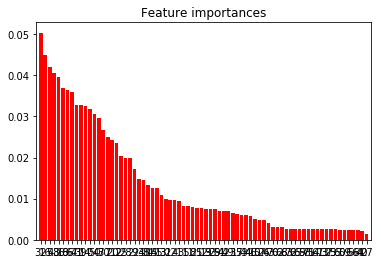

In [19]:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features


# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=42)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

#Print the feature ranking
print("Feature ranking:")

#for f in range(X.shape[1]):
#    print(X_head[f],"\t%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


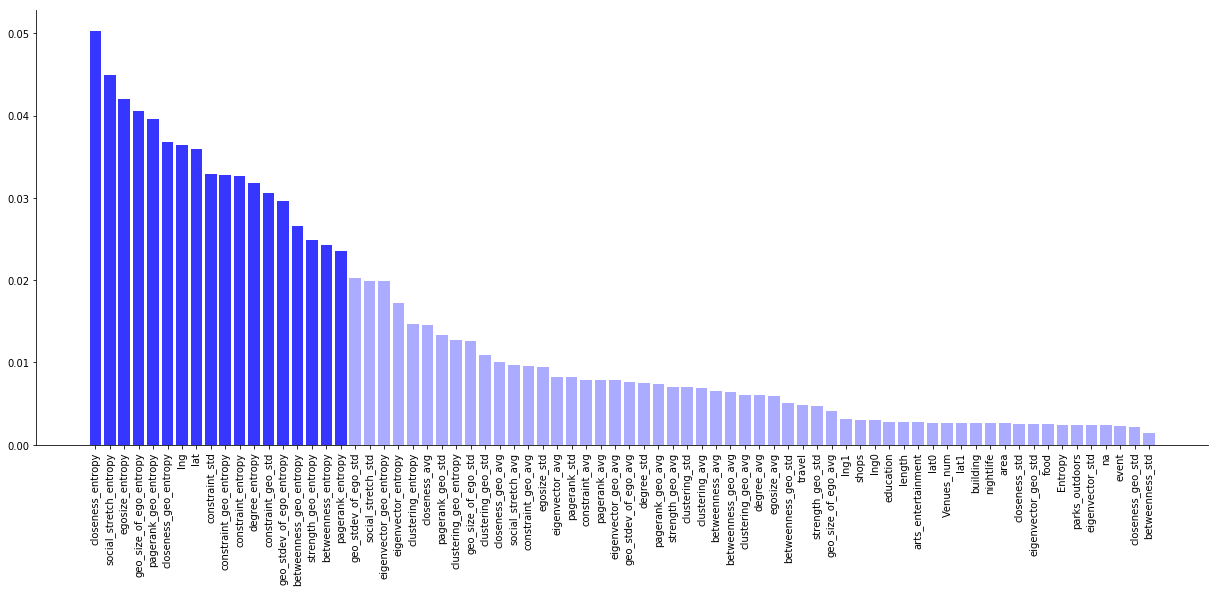

In [61]:

f, ax = plt.subplots(1, 1, figsize=(21, 8))
#ax.bar(range(X.shape[1]), importances[indices], color="r", align="center", alpha = 0.79)
ax.bar(range(X.shape[1])[0:18], importances[indices][0:18], color="b", align="center", alpha = 0.79)
ax.bar(range(X.shape[1])[18:], importances[indices][18:], color="b", align="center", alpha = 0.33)
ax.set_xticks(sorted(indices))
ax.set_xticklabels([X_head[i] for i in indices], rotation = 90)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('../../Pres/importance.png')
#indices#, indices



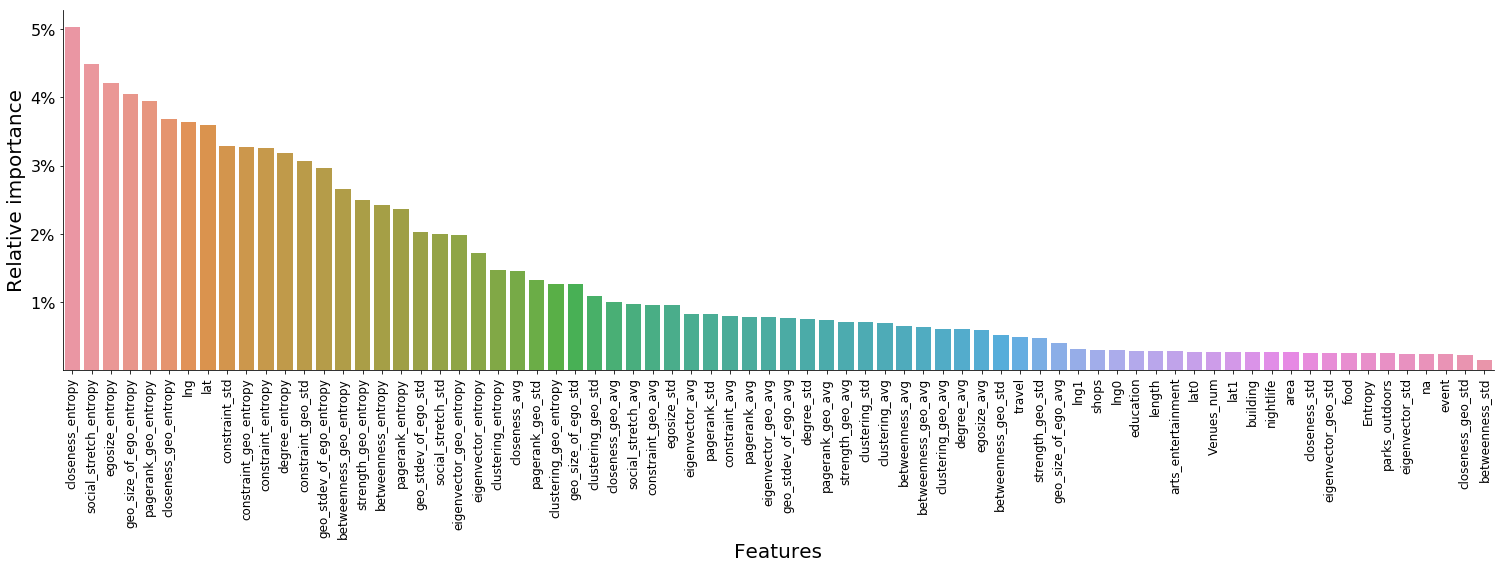

In [99]:
df = pd.DataFrame()
df['ind'] = [X_head[i] for i in indices]
df['val'] = [importances[i] for i in indices]
df        = df.sort_values(['val'], ascending = False)

f, ax = plt.subplots(1, 1, figsize=(21, 8))

sns.barplot(x="ind", y="val", data=df, ax = ax)

ax.set_xticks(sorted(indices))
ax.set_xticklabels([X_head[i] for i in indices], rotation = 90, fontsize = 12)

ax.set_yticks([0.01, 0.02, 0.03, 0.04, 0.05])
ax.set_yticklabels(['1%', '2%', '3%', '4%', '5%'], fontsize = 16)
ax.set_ylabel('Relative importance', fontsize = 20)
ax.set_xlabel('Features', fontsize = 20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('../../Pres/importance.png')



(array([19.,  5., 10.,  9.,  3.,  3.,  3.,  1.,  2.,  0.,  0.,  1.,  2.,
         4.,  1.,  1.,  1.,  3.,  3.,  3.]),
 array([0.00132293, 0.00329723, 0.00527152, 0.00724581, 0.0092201 ,
        0.01119439, 0.01316868, 0.01514298, 0.01711727, 0.01909156,
        0.02106585, 0.02304014, 0.02501443, 0.02698873, 0.02896302,
        0.03093731, 0.0329116 , 0.03488589, 0.03686019, 0.03883448,
        0.04080877]),
 <a list of 20 Patch objects>)

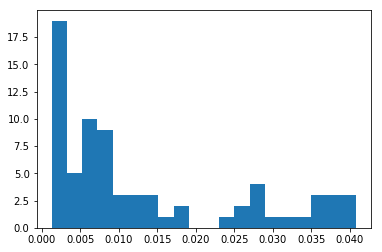

In [128]:
plt.hist(importances, bins = 20)

In [104]:
feat_imp = [(X_head[ind], imp) for ind, imp in enumerate(importances)]
feat_imp_sorted = sorted(feat_imp, key=lambda tup: tup[1], reverse = True)

ok_feats = []

for (feat, imp) in feat_imp_sorted:
    #print feat, '\t' , round(imp,3)
    if imp > 0.03:
        ok_feats.append(feat)
    
print ok_feats
    

['closeness_entropy', 'social_stretch_entropy', 'egosize_entropy', 'geo_size_of_ego_entropy', 'pagerank_geo_entropy', 'closeness_geo_entropy', 'lng', 'lat', 'constraint_std', 'constraint_geo_entropy', 'constraint_entropy', 'degree_entropy', 'constraint_geo_std']
